The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import jupyternotify
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from IPython.core.display import display, HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
display(HTML("<style>.container { width:100% !important; }</style>"))
ip=get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [4]:
def print_2images(image1,image2,title1='',title2=''):
    plt.clf()
    f=plt.figure(figsize=(5,5))
    f.tight_layout()
    ax=plt.subplot(1,2,1)
    ax.imshow(image1,cmap="gray")
    ax.set_title(title1,fontsize=30)
    ax=plt.subplot(1,2,2)
    ax.imshow(image2,cmap='gray')
    ax.set_title(title2,fontsize=30)
    plt.show()

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    # I dont use the bin_range argument at all.
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [6]:
def read_image(filename,final_size=64):
    img = cv2.imread(filename)
    scale = max(img.shape[0], img.shape[1], final_size) / final_size
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    rgb_resized_img = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    #return a final_size x final_size image in RGB color space with image values (0,255)
    return rgb_resized_img

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
       
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(200, 200), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

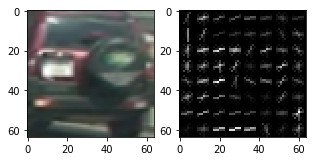

In [7]:
orient = 9 # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
img=read_image("./vehicles_combined/image0137.png",64)

feat,res=get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
print_2images(img,res)

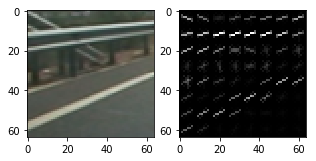

In [8]:
orient = 9 # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
img=read_image("./non-vehicles_combined/image1121.png",64)
feat,res=get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
print_2images(img,res)

In [9]:
num_vehicles=len([name for name in os.listdir('./vehicles_combined')])
num_non_vehicles=len([name for name in os.listdir('./non-vehicles_combined')])
print("Number of vehicle images:",num_vehicles)
print("Number of non-vehicle images:",num_non_vehicles)

#so that we have equal number of images from both classes
image_size=64 #will train on images that are 64x64

cars=[]
notcars=[]

path_prefix='./vehicles_combined/'
for f in os.listdir(path_prefix):
    try:
        img=read_image(path_prefix+f,final_size=image_size)
    except:
        print(f)
    cars.append(img)

path_prefix='./non-vehicles_combined/'
for f in os.listdir(path_prefix):
    try:
        img=read_image(path_prefix+f,final_size=image_size)
    except:
        print(f)
    notcars.append(img)

    
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:    ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Number of vehicle images: 6941
Number of non-vehicle images: 8968
118.7 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
6.14 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:     [ 0.  1.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  0.  0.  1.  0.]
0.00245 Seconds to predict 10 labels with SVC


In [10]:
clf_dump={}
clf_dump["color_space"]=color_space
clf_dump["orient"]=orient
clf_dump["pix_per_cell"]=pix_per_cell
clf_dump["cell_per_block"]=cell_per_block
clf_dump["hog_channel"]=hog_channel
clf_dump["spatial_size"]=spatial_size
clf_dump["hist_bins"]=hist_bins
clf_dump["image_size"]=image_size
clf_dump["X_scaler"]=X_scaler
clf_dump["classifier"]=svc
file=open("classifier"+color_space+".p",'wb')
pickle.dump(clf_dump,file)
file.close()

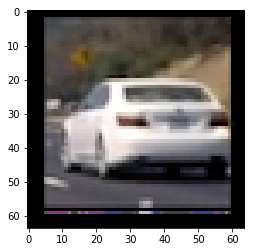

(64, 64, 3)
[ 1.]


In [11]:
unknown_image=read_image("./test_folder/car_frame.png",image_size)
plt.imshow(unknown_image)
plt.show()
print(unknown_image.shape)
#convert to list of images as expected by extract_features
unknown_image=[unknown_image]
unknown_image_features=extract_features(unknown_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X_unknown=X_scaler.transform(unknown_image_features)
print(svc.predict(X_unknown))

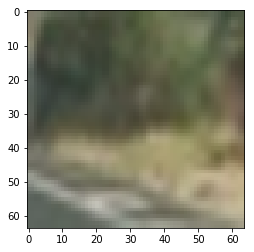

(64, 64, 3)
[ 0.]


In [12]:
unknown_image=read_image("./non-vehicles_combined/image113.png",image_size)
plt.imshow(unknown_image)
plt.show()
print(unknown_image.shape)
#convert to list of images as expected by extract_features
unknown_image=[unknown_image]
unknown_image_features=extract_features(unknown_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X_unknown=X_scaler.transform(unknown_image_features)
print(svc.predict(X_unknown))

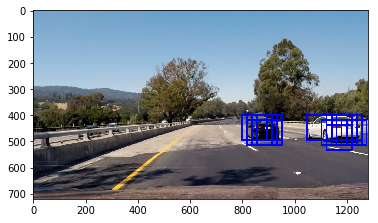

In [13]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (image_size, image_size))      
        #4) Extract features for that window
        test_img=[test_img]
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = cv2.imread('./test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
draw_image = np.copy(image)
y_start_stop = [400, 650] # Min and max in y to search in slide_window()


file=open("classifier"+color_space+".p",'rb')
load_classifier=pickle.load(file)
file.close()

color_space = load_classifier["color_space"]
ystart = 400
ystop = 650
scale = 1.7
classifier=load_classifier["classifier"]
X_scaler=load_classifier["X_scaler"]
orient=load_classifier["orient"]
pix_per_cell =load_classifier["pix_per_cell"]
cell_per_block =load_classifier["cell_per_block"]
hog_channel =load_classifier["hog_channel"]#use all hog channels
spatial_size =load_classifier["spatial_size"]
hist_bins = load_classifier["hist_bins"]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image, windows, classifier, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

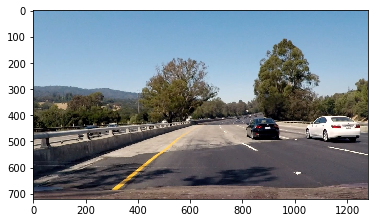

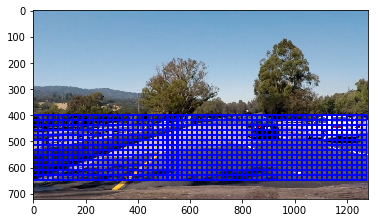

In [12]:
image = cv2.imread('./test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
plt.imshow(image)
plt.show()
draw_image = np.copy(image)
draw_image = np.copy(image)
window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

In [19]:

#expects a RGB image
def find_cars(img, color_space,ystart, ystop, scale, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,xstart=0,xstop=0):

    draw_img = np.copy(img)
   # img = img.astype(np.float32)/255
    if xstart==0 and xstop==0:
        img_tosearch = img[ystart:ystop,:,:]
    else:
        img_tosearch = img[ystart:ystop,xstart:xstop]
    if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
            else: ctrans_tosearch = np.copy(img_tosearch)      

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
    
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = classifier.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = xstart+np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                #plt.imshow(draw_img)
                #plt.show()
                if len(box)==0:
                    #[x1,y1,x2,y2]
                    box=[[xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart]]
                else:
                    box.append([xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart])
    return draw_img,box
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[1]:box[3], box[0]:box[2]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    global car_loc
    # Iterate through all detected cars
    car_loc=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #ystart,ystop,xstart,stop
        if len(car_loc)==0:
            car_loc=[[np.int(bbox[0][1]),np.int(bbox[0][1])+100,np.int(bbox[0][0]),np.int(bbox[0][0])+150]]
        else:
            car_loc=car_loc+[[np.int(bbox[0][1]),np.int(bbox[0][1])+100,np.int(bbox[0][0]),np.int(bbox[0][0])+150]]
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.rectangle(img,(np.int(bbox[0][0]),np.int(bbox[0][1])),(np.int(bbox[0][0])+150,np.int(bbox[0][1])+100),(0,0,255),6)
    # Return the image
    return img

def process_image_final(img):
    global car_loc,f_num,labels_old
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_img = np.copy(img)
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9 # HOG orientations
    pix_per_cell = 8  # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    ystart = 400
    ystop = 600
    x_start=0
    x_stop=img.shape[1]
    scale = 1.6
    out=[]
    out_img,box = find_cars(img, color_space,ystart, ystop, scale, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
    out=out_img
    boxs=box
    # To find cards farther away
    scale_list=[1.4,1]
    for s in scale_list:
        x_start=300
        x_stop=1000
        y_start=400
        y_Stop=500
        out_img,box = find_cars(img, color_space,ystart, ystop, s, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
        #out=np.hstack((out,out_img))
        if len(boxs)==0:
            boxs=box
        else:
            boxs=boxs+box
    
    #finding cars in old location,using a different scale parameter 
    scale_list=[0.8,0.6]
    for car in car_loc:
        for s in scale_list:
            y_start=car[0]
            y_stop=car[1]
            x_start=car[2]
            x_stop=car[3]
            scale=s
            out_img,box = find_cars(img, color_space,y_start, y_stop, s, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
            out=out+out_img
            if len(boxs)==0:
                boxs=box
            else:
                boxs=boxs+box
            if (x_start-50>0):
                x_start=x_start-50
                x_stop=x_stop-50
            out_img,box = find_cars(img, color_space,y_start, y_stop, s, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
            out=out+out_img
            if len(boxs)==0:
                boxs=box
            else:
                boxs=boxs+box
    #apply threshold to make into one square per car and also update car_loc with new car_locations(boundary of final boxes+margin)
    heat = add_heat(heat,boxs)

    heat=apply_threshold(heat,3)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels_new = label(heatmap)
    #only update labesl every 6th frame
    if f_num%6==0:
        labels=labels_new
        labels_old=labels
    else:
        labels=labels_old
        
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #plt.figure(figsize=(10,10))
    #plt.imshow(out)
    #plt.show()
    f_num=f_num+1
    return draw_img

In [14]:
f_num=0
car_loc=[]
labels_old=[]
video = 'subclip_output_project_video'+color_space+'.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(38.5,38.9)
clip = clip1.fl_image(process_image_final) #NOTE: this function expects color images!!
%time clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video subclip_output_project_videoYCrCb.mp4
[MoviePy] Writing video subclip_output_project_videoYCrCb.mp4


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip_output_project_videoYCrCb.mp4 

CPU times: user 6.58 s, sys: 155 ms, total: 6.73 s
Wall time: 6.98 s


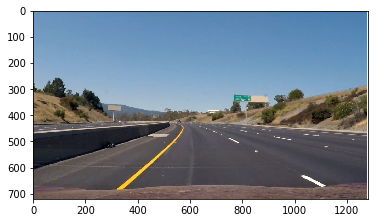

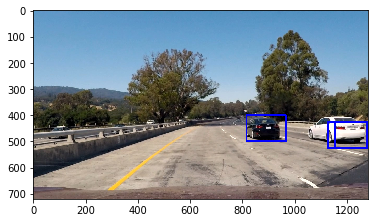

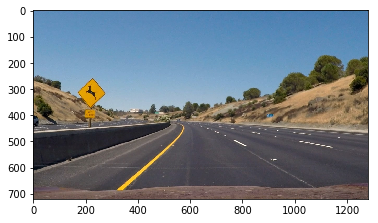

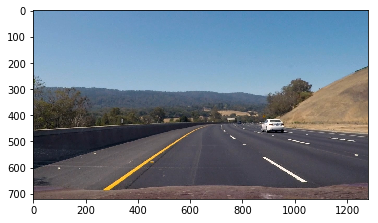

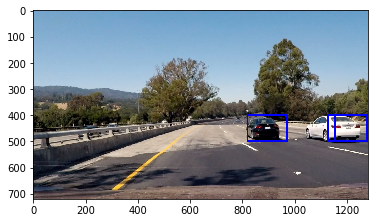

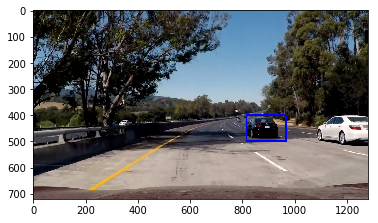

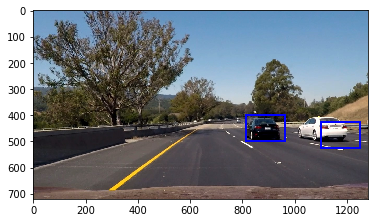

In [20]:
for f in os.listdir('./test_images/'):
    f_num=0
    image=cv2.imread('./test_images/'+f)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    car_loc=[]
    res=process_image_final(img)
    plt.imshow(res)
    plt.show()


In [15]:
def process_image_final(img):
    global car_loc,f_num,labels_old
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_img = np.copy(img)
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9 # HOG orientations
    pix_per_cell = 8  # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    ystart = 400
    ystop = 600
    x_start=0
    x_stop=img.shape[1]
    scale = 1.6
    out=[]
    out_img,box = find_cars(img, color_space,ystart, ystop, scale, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
    out=out_img
    boxs=box
    # To find cards farther away
    scale_list=[1.4,1]
    for s in scale_list:
        x_start=300
        x_stop=1000
        y_start=400
        y_Stop=500
        out_img,box = find_cars(img, color_space,ystart, ystop, s, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
        #out=np.hstack((out,out_img))
        if len(boxs)==0:
            boxs=box
        else:
            boxs=boxs+box
    
    #finding cars in old location,using a different scale parameter 
    scale_list=[0.8,0.6]
    for car in car_loc:
        for s in scale_list:
            y_start=car[0]
            y_stop=car[1]
            x_start=car[2]
            x_stop=car[3]
            scale=s
            out_img,box = find_cars(img, color_space,y_start, y_stop, s, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
            out=out+out_img
            if len(boxs)==0:
                boxs=box
            else:
                boxs=boxs+box
            if (x_start-50>0):
                x_start=x_start-50
                x_stop=x_stop-50
            out_img,box = find_cars(img, color_space,y_start, y_stop, s, classifier, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,x_start,x_stop)
            out=out+out_img
            if len(boxs)==0:
                boxs=box
            else:
                boxs=boxs+box
    #apply threshold to make into one square per car and also update car_loc with new car_locations(boundary of final boxes+margin)
    heat = add_heat(heat,boxs)

    heat=apply_threshold(heat,3)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels_new = label(heatmap)
    #only update labesl every 6th frame
    if f_num%6==0:
        labels=labels_new
        labels_old=labels
    else:
        labels=labels_old
        
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #plt.figure(figsize=(10,10))
    #plt.imshow(out)
    #plt.show()
    f_num=f_num+1
    return draw_img

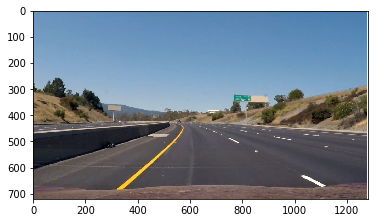

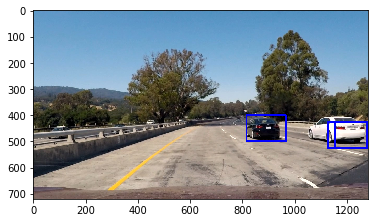

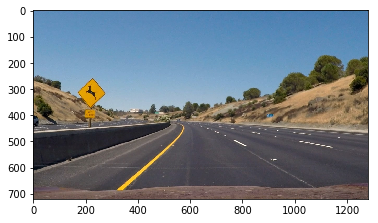

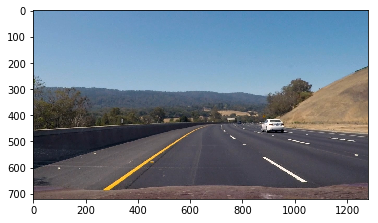

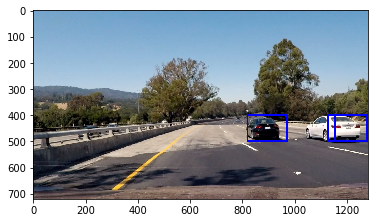

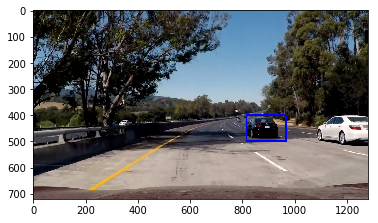

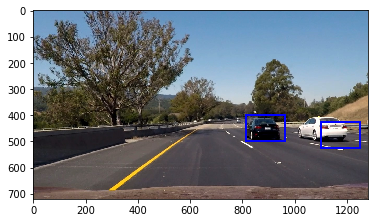

In [16]:
for f in os.listdir('./test_images/'):
    f_num=0
    image=cv2.imread('./test_images/'+f)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    car_loc=[]
    res=process_image_final(img)
    plt.imshow(res)
    plt.show()


In [220]:
f_num=0
car_loc=[]
labels_old=[]
video = 'output_emptyroad_video'+color_space+'.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(1,1.7)
clip = clip1.fl_image(process_image_final) #NOTE: this function expects color images!!
%time clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video output_emptyroad_videoYCrCb.mp4
[MoviePy] Writing video output_emptyroad_videoYCrCb.mp4



100%|██████████| 18/18 [00:22<00:00,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_emptyroad_videoYCrCb.mp4 

CPU times: user 22 s, sys: 437 ms, total: 22.4 s
Wall time: 22.7 s


In [221]:
f_num=0
car_loc=[]
labels_old=[]
video = 'output_test_video'+color_space+'.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(process_image_final) #NOTE: this function expects color images!!
%time clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video output_test_videoYCrCb.mp4
[MoviePy] Writing video output_test_videoYCrCb.mp4



 97%|█████████▋| 38/39 [01:18<00:02,  2.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_videoYCrCb.mp4 

CPU times: user 1min 17s, sys: 959 ms, total: 1min 18s
Wall time: 1min 19s


In [ ]:
f_num=0
car_loc=[]
labels_old=[]
video = 'output_farcar_video'+color_space+'.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(21,22)
clip = clip1.fl_image(process_image_final) #NOTE: this function expects color images!!
%time clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video output_farcar_videoYCrCb.mp4
[MoviePy] Writing video output_farcar_videoYCrCb.mp4



 96%|█████████▌| 25/26 [00:40<00:01,  1.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_farcar_videoYCrCb.mp4 

CPU times: user 40.4 s, sys: 608 ms, total: 41 s
Wall time: 41.4 s


In [17]:
f_num=0
car_loc=[]
labels_old=[]
video = '1_output_farcar_video'+color_space+'.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(18,30)
clip = clip1.fl_image(process_image_final) #NOTE: this function expects color images!!
%time clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video 1_output_farcar_videoYCrCb.mp4
[MoviePy] Writing video 1_output_farcar_videoYCrCb.mp4


100%|█████████▉| 300/301 [09:07<00:02,  2.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 1_output_farcar_videoYCrCb.mp4 

CPU times: user 9min 2s, sys: 7.14 s, total: 9min 9s
Wall time: 9min 8s


In [18]:
f_num=0
car_loc=[]
labels_old=[]
video = 'output_project_video'+color_space+'.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image_final) #NOTE: this function expects color images!!
%time clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video output_project_videoYCrCb.mp4
[MoviePy] Writing video output_project_videoYCrCb.mp4


100%|█████████▉| 1260/1261 [36:18<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_videoYCrCb.mp4 

CPU times: user 35min 57s, sys: 29.8 s, total: 36min 27s
Wall time: 36min 19s
